In [4]:
import os
import pandas as pd
import numpy as np
import ants
import itk
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ants
import nibabel as nib
import dicom2nifti



In [2]:
cn_dict_with_images = np.load("data/cn_dict_with_images.npy",allow_pickle='TRUE').item()
ad_dict_with_images = np.load("data/ad_dict_with_images.npy",allow_pickle='TRUE').item()
smci_dict_with_images = np.load("data/smci_dict_with_images.npy",allow_pickle='TRUE').item()
pmci_dict_with_images = np.load("data/pmci_dict_with_images.npy",allow_pickle='TRUE').item()

In [5]:
example_path = '/Volumes/Extreme SSD/ADNI/002_S_0295/MP-RAGE/2006-04-18_08_20_30.0/I13722/'

example_image = itk.imread(example_path)

#ants_example_image = ants.image_read(example_path)

**Borrowed the following code from Lucas**

In [4]:
def show_slices(slices,img):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(11,8)
    for i, slice in enumerate(slices):

        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle(f"Center slices for current MRI image \n Image size: {img.shape}",fontsize=20)
    # print("image size:",img.shape)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20)
    plt.show()

def show_brain_center_slice(img: np.memmap):
    slice_0 = img[int(img.shape[0]/2), :, :]
    slice_1 = img[:, int(img.shape[1]/2), :]
    slice_2 = img[:, :, int(img.shape[2]/2)]
    show_slices([slice_0, slice_1, slice_2],img)

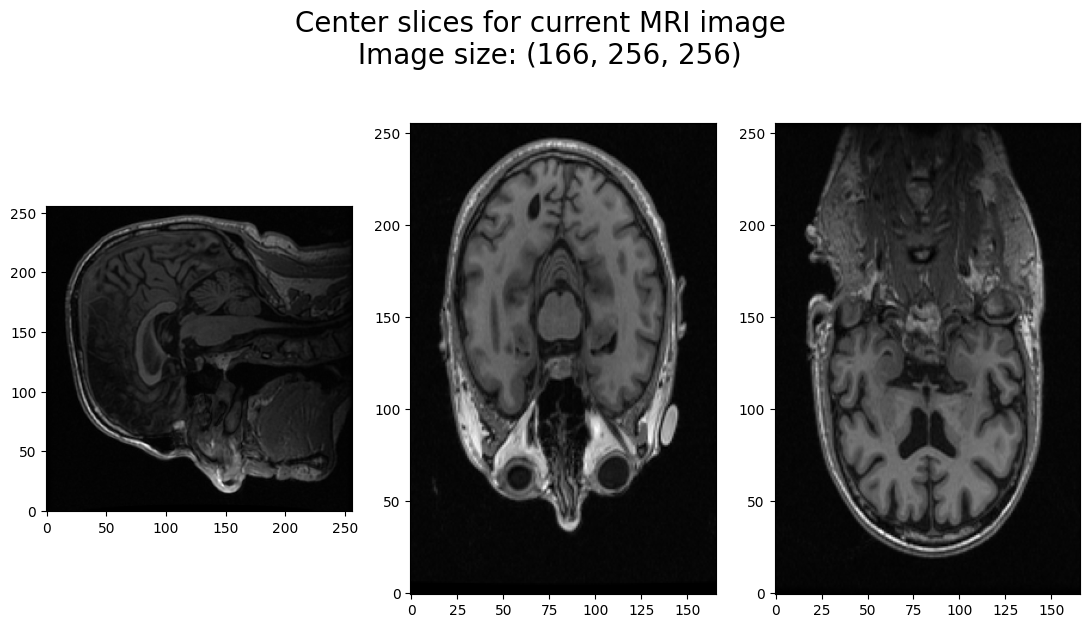

In [5]:
show_brain_center_slice(example_image)

In [6]:
corrected_image = itk.n4_bias_field_correction_image_filter(example_image)

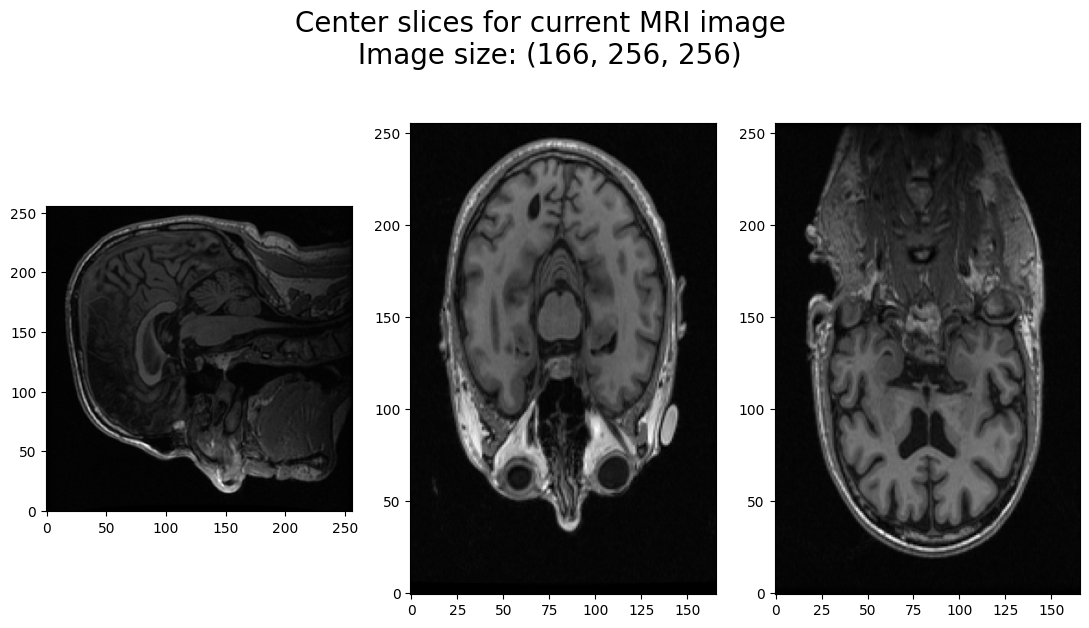

In [7]:
show_brain_center_slice(corrected_image)

In [8]:
#reader = sitk.ImageSeriesReader()
#dicom_names = reader.GetGDCMSeriesFileNames('/Volumes/Extreme SSD/ADNI/002_S_0295/MP-RAGE/2006-04-18_08_20_30.0/I13722/')
#reader.SetFileNames(dicom_names)
#image = reader.Execute()

#image = sitk.GetImageFromArray(test_arr)

# Added a call to PermuteAxes to change the axes of the data
itk_image = corrected_image

new_sitk_image = sitk.GetImageFromArray(itk.GetArrayFromImage(itk_image), isVector=itk_image.GetNumberOfComponentsPerPixel()>1)
new_sitk_image.SetOrigin(tuple(itk_image.GetOrigin()))
new_sitk_image.SetSpacing(tuple(itk_image.GetSpacing()))
new_sitk_image.SetDirection(itk.GetArrayFromMatrix(itk_image.GetDirection()).flatten()) 

new_sitk_image = sitk.PermuteAxes(new_sitk_image, [2, 1, 0])

sitk.WriteImage(new_sitk_image, 'M0_1.nii.gz')

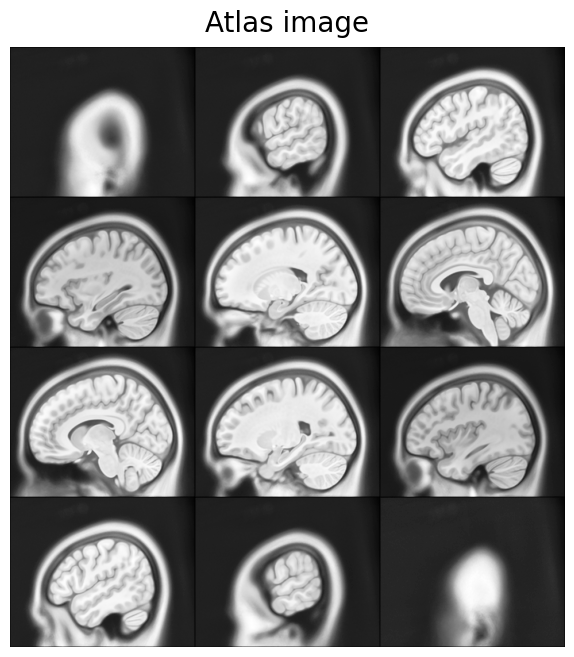

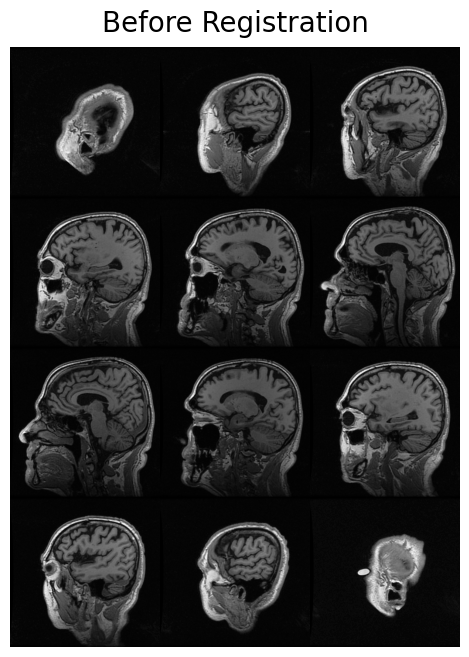

In [9]:
mi = ants.image_read("M0_1.nii.gz")

fi = ants.image_read('//Users/olath/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii')

fi = ants.n4_bias_field_correction(fi)

fi.plot(title='Atlas image')
mi.plot(title='Before Registration')

mytx = ants.registration(fixed=fi, moving=mi, type_of_transform = 'SyN' )


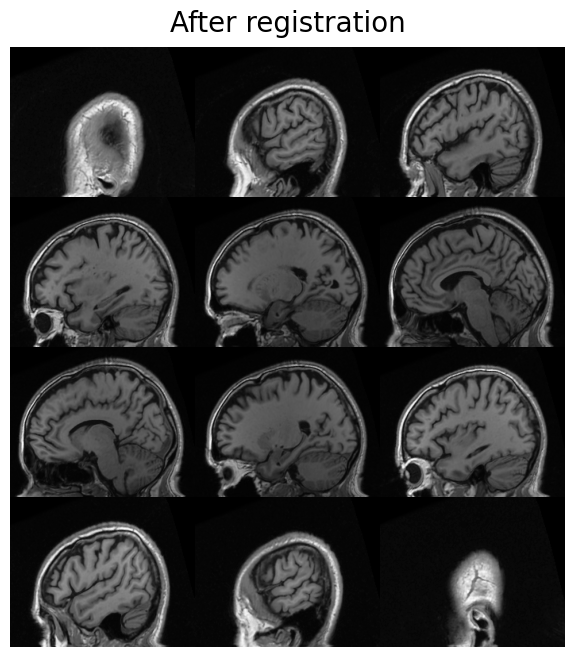

In [10]:
mywarpedimage = ants.apply_transforms(fixed=fi, moving=mi,
                                      transformlist=mytx['fwdtransforms'])

mywarpedimage.plot(title='After registration')

In [12]:
center_dim = [int(np.ceil(x/2)) for x in mywarpedimage.shape]
lower_dim = [int(x - 50) for x in center_dim]
upper_dim = [int(x + 50) for x in center_dim]

cropped_image =  ants.crop_indices(mywarpedimage,lowerind = lower_dim,upperind = upper_dim)

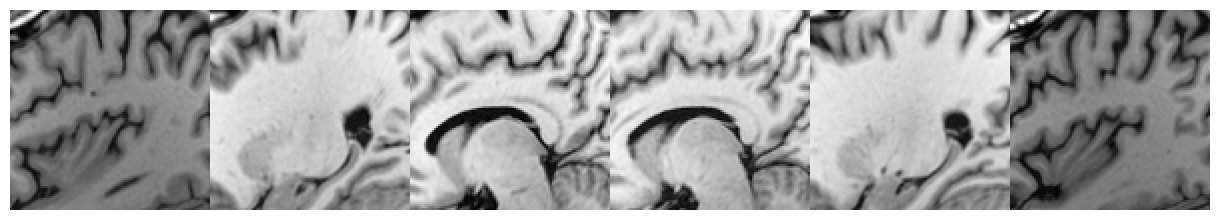

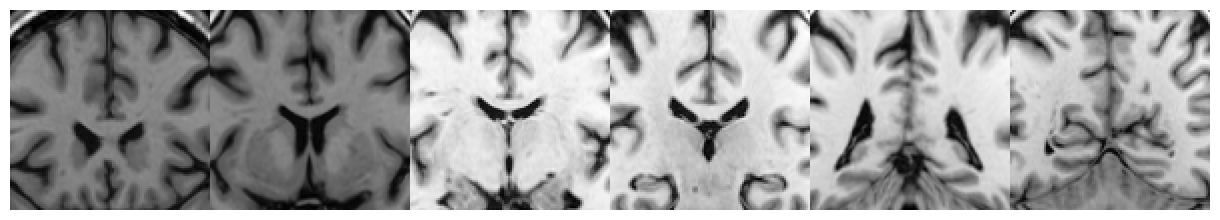

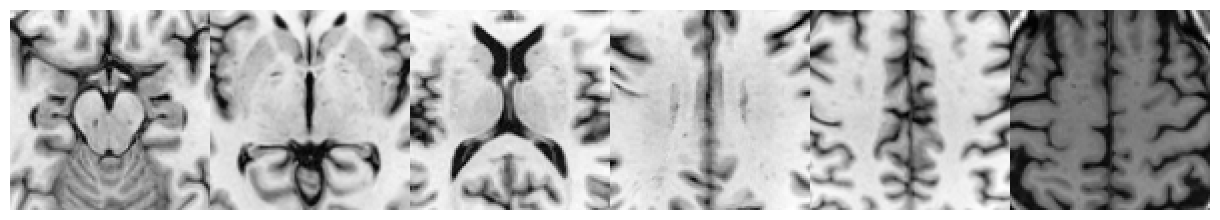

In [98]:
cropped_image.plot(axis =0,figsize=2,nslices=6)
cropped_image.plot(axis =1,figsize=2,nslices=6)
cropped_image.plot(axis =2,figsize=2,nslices=6)

In [14]:
ants.image_write(cropped_image,"cropped.nii.gz")

In [14]:
def preprocess(in_path, out_path, image_name):

    dicom2nifti.dicom_series_to_nifti(in_path, 'temp.nii.gz', reorient_nifti=True)

    mi = ants.image_read('temp.nii.gz')

    mi = ants.n4_bias_field_correction(mi)

    fi = ants.image_read('//Users/olath/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii')

    mytx = ants.registration(fixed=fi, moving=mi, type_of_transform='SyN' ,grad_step=0.1 )

    mywarpedimage = ants.apply_transforms(fixed=fi, moving=mi,
                                      transformlist=mytx['fwdtransforms'])
    
    center_dim = [int(np.ceil(x/2)) for x in mywarpedimage.shape]
    lower_dim = [int(x - 50) for x in center_dim]
    upper_dim = [int(x + 50) for x in center_dim]

    cropped_image =  ants.crop_indices(mywarpedimage,lowerind = lower_dim,upperind = upper_dim)

    ants.image_write(cropped_image,out_path + image_name + '.nii.gz')



    

In [15]:
preprocess(example_path, example_path, 'test')

In [16]:
def run_preprocessing(in_dict, out_path):

    counter = 0

    for patient in in_dict:
        images = list()
        path = ('/Volumes/Extreme SSD/ADNI/' + str(patient))

        for visit in in_dict[patient]:

            if len(visit) == 4:

                for image in visit[3]:

                    images.append(image)


        for subdir, dirs, files in os.walk(path):

            for image in images:
    
                if str(image) in str(subdir):

                    preprocess(subdir,out_path, str(image))
                    counter += 1
                    print('Processed picture nr: ', counter)




In [21]:
run_preprocessing(pmci_dict_with_images, '/Volumes/Extreme SSD/ADNI_MPRAGE_TEST/PMCI/')

Processed picture nr:  1
Processed picture nr:  2
Processed picture nr:  3
Processed picture nr:  4
Processed picture nr:  5
Processed picture nr:  6
Processed picture nr:  7
Processed picture nr:  8
Processed picture nr:  9
Processed picture nr:  10
Processed picture nr:  11
